In [1]:
import torch
import torch.nn as nn
from Nail_dataset import get_dataset
from torch.utils.data import DataLoader
from Model import get_model
import matplotlib.pyplot as plt
import cv2
import torch.nn.functional as F
from torch.autograd import Variable
import numpy as np
from torch.nn.functional import binary_cross_entropy
import torch
from torch.utils.tensorboard import SummaryWriter



In [2]:
import os    
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [3]:
class FocalLoss(nn.Module):
    """
    Focal Loss for Dense Object Detection [https://arxiv.org/abs/1708.02002]
    Digest the paper as below:
        α, balances the importance of positive/negative examples
        γ, focusing parameter that controls the strength of the modulating term
            CE(pt) = −log(pt) ==> pt = exp(-CE)
            FL(pt) = −α((1 − pt)^γ) * log(pt)
        In general α should be decreased slightly as γ is increased (for γ = 2, α = 0.25 works best).
    """
    def __init__(self, focusing_param=2, balance_param=0.25):
        super().__init__()
        self.gamma = focusing_param
        self.alpha = balance_param

    def forward(self, inputs, targets, weights=None):
        logpt = -binary_cross_entropy(inputs, targets, weights)
        pt = torch.exp(logpt)
        # compute the loss
        focal_loss = -((1-pt)**self.gamma) * logpt
        balanced_focal_loss = self.alpha * focal_loss
        return balanced_focal_loss



In [4]:
class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=0.00001):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
#         inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        
        return 1-dice

In [5]:
class IoULoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super().__init__()

    def forward(self, inputs, targets):
        smooth = 0.001
        num = targets.size(0) # number of batches
#         print(num)
        m1 = inputs.view(num, -1)
        m2 = targets.view(num, -1)
        intersection = (m1 * m2)
#         print(intersection)
        score = (intersection.sum() + smooth) / (m1.sum() + m2.sum() - intersection.sum() + smooth)
        iou = score.sum() / num
        # three kinds of loss formulas: (1) 1 - iou (2) -iou (3) -torch.log(iou)
        return 1. - iou
    

In [6]:
class IoUScore(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super().__init__()

    def forward(self, inputs, targets):
        #(batch_size, 256, 256)
        smooth = 0.00001
        num = targets.size(0) # number of batches
#         print("num", num)
        m1 = inputs.view(num, -1)
        m2 = targets.view(num, -1)
#         print(m1.shape)
        intersection = (m1 * m2)
#         print("intersector", intersection)
#         print(intersection)
#         print("m1", m1)
#         print("m2", m2)
#         print("intersection.sum(1)", intersection.sum(1))
#         print("m1.sum(1)", m1.sum(1))
#         print("m2.sum(1)", m2.sum(1))
        score = (intersection.sum(1) + smooth) / (m1.sum(1) + m2.sum(1) - intersection.sum(1) + smooth)
        iou = score.sum() / num
        # three kinds of loss formulas: (1) 1 - iou (2) -iou (3) -torch.log(iou)
        return iou

In [7]:

dataset = get_dataset("val", augment = True)

dataloader = DataLoader(dataset, batch_size=1, shuffle=True)
model = get_model()

# model.load_state_dict(torch.load("D:/Project/Tony/anemia/code/keras_version/models/model_40.pth"))
model.load_state_dict(torch.load("D:/Project/Tony/anemia/code/keras_version/models/best_model.pth"))

loss_fn = DiceLoss()
criterion = IoUScore()


In [8]:
print(len(dataloader))

50


In [37]:
model.eval()
device = "cpu"
print(device)
model = model.to(device)
size = len(dataloader)
total_loss=0
total_score = 0
with torch.no_grad():
    for batch, (X, y, image) in enumerate(dataloader):
        X = X.to(device)
        y = y.to(device)
        X = X.float()
        y = y.float()
        pred = model(X)
        pred = F.sigmoid(pred)
        pred = pred.reshape(1,256,256)
        y = y.reshape(1,256,256)
        loss = loss_fn((pred), y)
        score = criterion((pred), y)
        total_loss+=loss
        total_score+=score
        if(batch%10==0):
            print(batch)
        print
        break
    print(total_loss/len(dataloader))




cpu
0
tensor(0.0062)


In [38]:
print(total_loss/len(dataloader))
print(total_score/len(dataloader))

tensor(0.0062)
tensor(0.0105)


In [39]:
/

()

tensor(0.3100) tensor(0.5267)


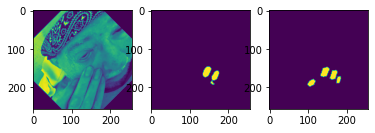

In [40]:
print(loss, score)
plt.subplot(1,3,1)
plt.imshow(X[0][0])
plt.subplot(1,3,2)
plt.imshow(pred.cpu().detach().numpy()[0])
plt.subplot(1,3,3)
plt.imshow(y.cpu().detach().numpy()[0])

In [345]:
input = torch.tensor([[0,0],[0,0]])
mask = torch.tensor([[1,1],[0,0]])
print(loss_fn(input,mask))

tensor(1.0000)


In [44]:
!nvidia-smi

Sun Aug 07 22:17:16 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 457.51       Driver Version: 457.51       CUDA Version: 11.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 3090   WDDM  | 00000000:01:00.0  On |                  N/A |
| 58%   70C    P2   156W / 350W |   6662MiB / 24576MiB |     19%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------